In [1]:
import pandas as pd
import os
import time
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor, plot_importance
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout

from datetime import datetime, date

Using TensorFlow backend.


In [2]:
#01-01-2013 -> 31-12-2014
sample_sub = pd.read_csv('sample_submission.csv.gz')
data = pd.read_csv('sales_train.csv.gz')
test = pd.read_csv('test.csv.gz')
items = pd.read_csv('items.csv')
items_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

sample_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## EDA

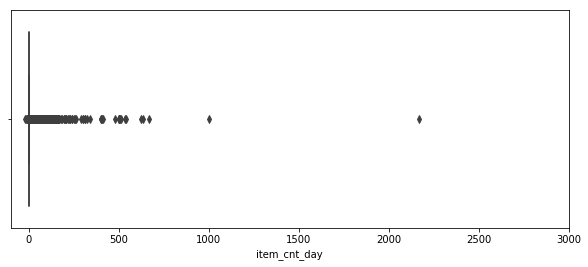

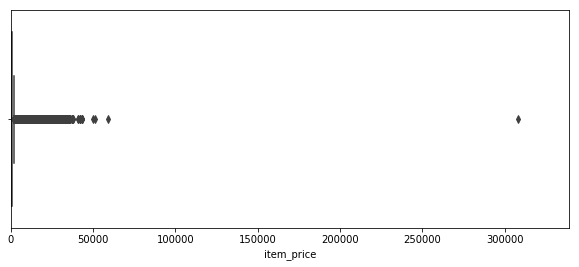

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=data.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(data.item_price.min(), data.item_price.max()*1.1)
sns.boxplot(x=data.item_price)

In [4]:
#data = data[data.item_price<100000]
#data = data[data.item_cnt_day<1001]

In [5]:
test_shops = test.shop_id.unique()
data = data[data.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
data = data[data.item_id.isin(test_items)]

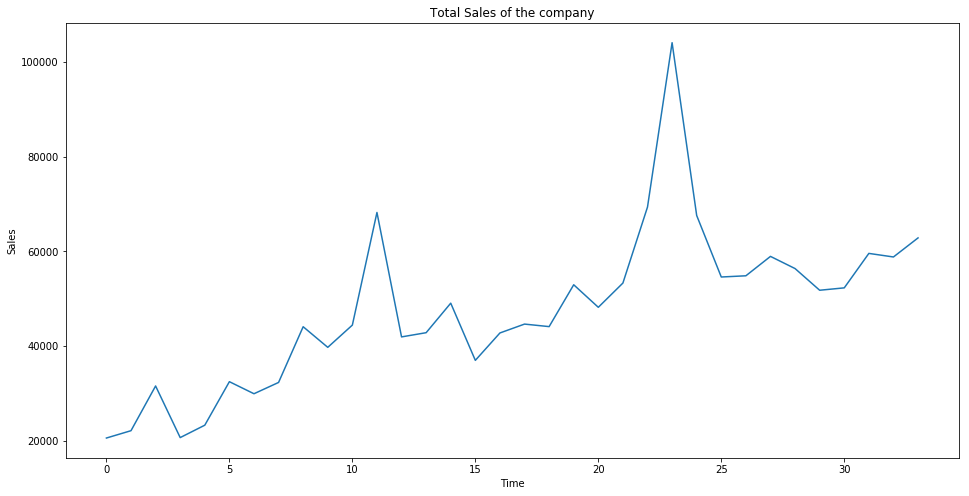

In [6]:
ts=data.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

<Figure size 1152x864 with 0 Axes>

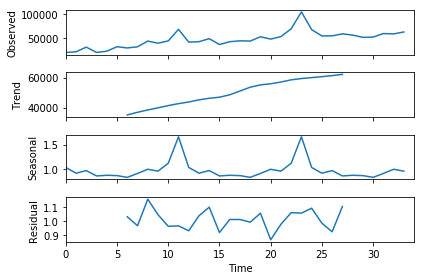

In [7]:
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [8]:
print(data.shape)

data['date'] = pd.to_datetime(data.date, format = '%d.%m.%Y')
data['day'] = data.date.dt.day
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
data['weekday'] = data.date.dt.dayofweek

data = data.merge(items, how = 'inner')
data.drop(['item_name'], inplace = True, axis = 1)
data['revenue'] = data['item_price'] * data['item_cnt_day']

print(data.shape)
data.head()

(1224439, 6)
(1224439, 12)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,weekday,item_category_id,revenue
0,2013-01-02,0,59,22154,999.0,1.0,2,1,2013,2,37,999.0
1,2013-01-23,0,24,22154,999.0,1.0,23,1,2013,2,37,999.0
2,2013-01-02,0,25,22154,999.0,1.0,2,1,2013,2,37,999.0
3,2013-01-03,0,25,22154,999.0,1.0,3,1,2013,3,37,999.0
4,2013-01-20,0,25,22154,999.0,1.0,20,1,2013,6,37,999.0


## Scaling

In [9]:
#scaler = MinMaxScaler()
#cnt_scaler = MinMaxScaler()

#scaler.fit(data.item_price.as_matrix().reshape(-1, 1))
#cnt_scaler.fit(data.item_cnt_day.as_matrix().reshape(-1, 1))

#data.item_price = scaler.transform(data.item_price.as_matrix().reshape(-1, 1))
#data.item_cnt_day = cnt_scaler.transform(data.item_cnt_day.as_matrix().reshape(-1, 1))

## Grouping

In [10]:
data = data.pivot_table(index = ['shop_id','item_id'], values = ['item_cnt_day'], 
                        columns = ['date_block_num'], fill_value = 0).reset_index()
print(data.shape)
data.head()

(111404, 36)


shop_id item_id item_cnt_day                                \
date_block_num                            0    1    2    3    4    5    6   
0                    2      30          0.0  0.0  1.0  0.0  0.0  1.0  0.0   
1                    2      31          0.0  1.0  1.0  1.0  0.0  0.0  0.0   
2                    2      32          0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3                    2      33          1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4                    2      53          0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                     ...                                                    
date_block_num    7  ...   24   25   26   27   28   29   30   31   32   33  
0               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2               0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
3               0.0  ...  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  
4               0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]

In [11]:
data = pd.merge(test, data, on = ['item_id','shop_id'], how = 'left')
print(data.shape)
data.fillna(0,inplace = True) 
data.head()

C:\Users\enric\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\enric\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


(214200, 37)


,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
data.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
data.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
data.shape

(214200, 34)

## Split training tests

In [15]:
#Separate the X and the y
X_train = np.expand_dims(data.values[:,0:31], axis = 2)
y_train = np.expand_dims(data.values[:, 32], axis = 2)
X_valid = np.expand_dims(data.values[:, 1:32], axis = 2)
y_valid = np.expand_dims(data.values[:, 33], axis = 2)
X_test =  np.expand_dims(data.values[:, 3: 34], axis = 2)

X = np.expand_dims(data.values[:,:-1], axis = 2)
y =np.expand_dims(data.values[:,-1:], axis = 2).reshape(X_train.shape[0], 1)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape)
print(X.shape, y.shape)

(214200, 31, 1) (214200, 1) (214200, 31, 1) (214200, 1) (214200, 31, 1)
(214200, 33, 1) (214200, 1)


C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


## Model

In [18]:
my_model = Sequential()
my_model.add(LSTM(units = 64,input_shape = (31,1), return_sequences = True))
my_model.add(Dropout(0.5))
my_model.add(LSTM(32))
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation = 'linear'))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 31, 64)            16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [19]:
my_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 512, epochs = 3, verbose = 1)

Train on 214200 samples, validate on 214200 samples
Epoch 1/3
214200/214200 [==============================] - 113s 525us/step - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 1.3663 - val_mean_squared_error: 1.3663
Epoch 2/3
214200/214200 [==============================] - 108s 504us/step - loss: 0.1506 - mean_squared_error: 0.1506 - val_loss: 1.3654 - val_mean_squared_error: 1.3654
Epoch 3/3
214200/214200 [==============================] - 174s 812us/step - loss: 0.1500 - mean_squared_error: 0.1500 - val_loss: 1.3660 - val_mean_squared_error: 1.3660


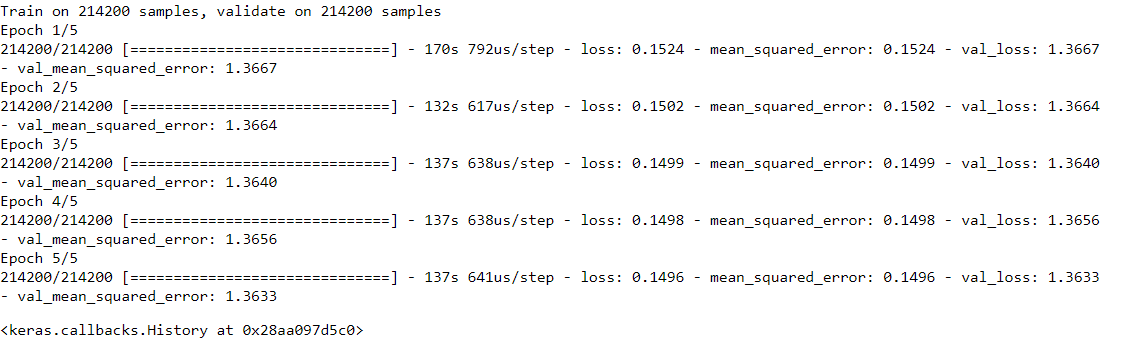

### Eval

In [20]:
#y_train_pred = my_model.predict(X_train, verbose = 1).reshape(X_test.shape[0])
y_val_pred = my_model.predict(X_valid, verbose = 1).reshape(X_test.shape[0])
#print(mean_absolute_error(y_train, y_train_pred)) #0.25782864419728463
#print(mean_squared_error(y_train, y_train_pred)) #0.490053948069112
#print(np.sqrt(mean_squared_error(y_train, y_train_pred))) #0.490053948069112

print(mean_absolute_error(y_valid.reshape(X_test.shape[0]), y_val_pred))
print(mean_squared_error(y_valid.reshape(X_test.shape[0]), y_val_pred)) #1.36
print(np.sqrt(mean_squared_error(y_valid.reshape(X_test.shape[0]), y_val_pred)))

214200/214200 [==============================] - 120s 559us/step
0.20618906486651498
1.3659668723589806
1.1687458544777733


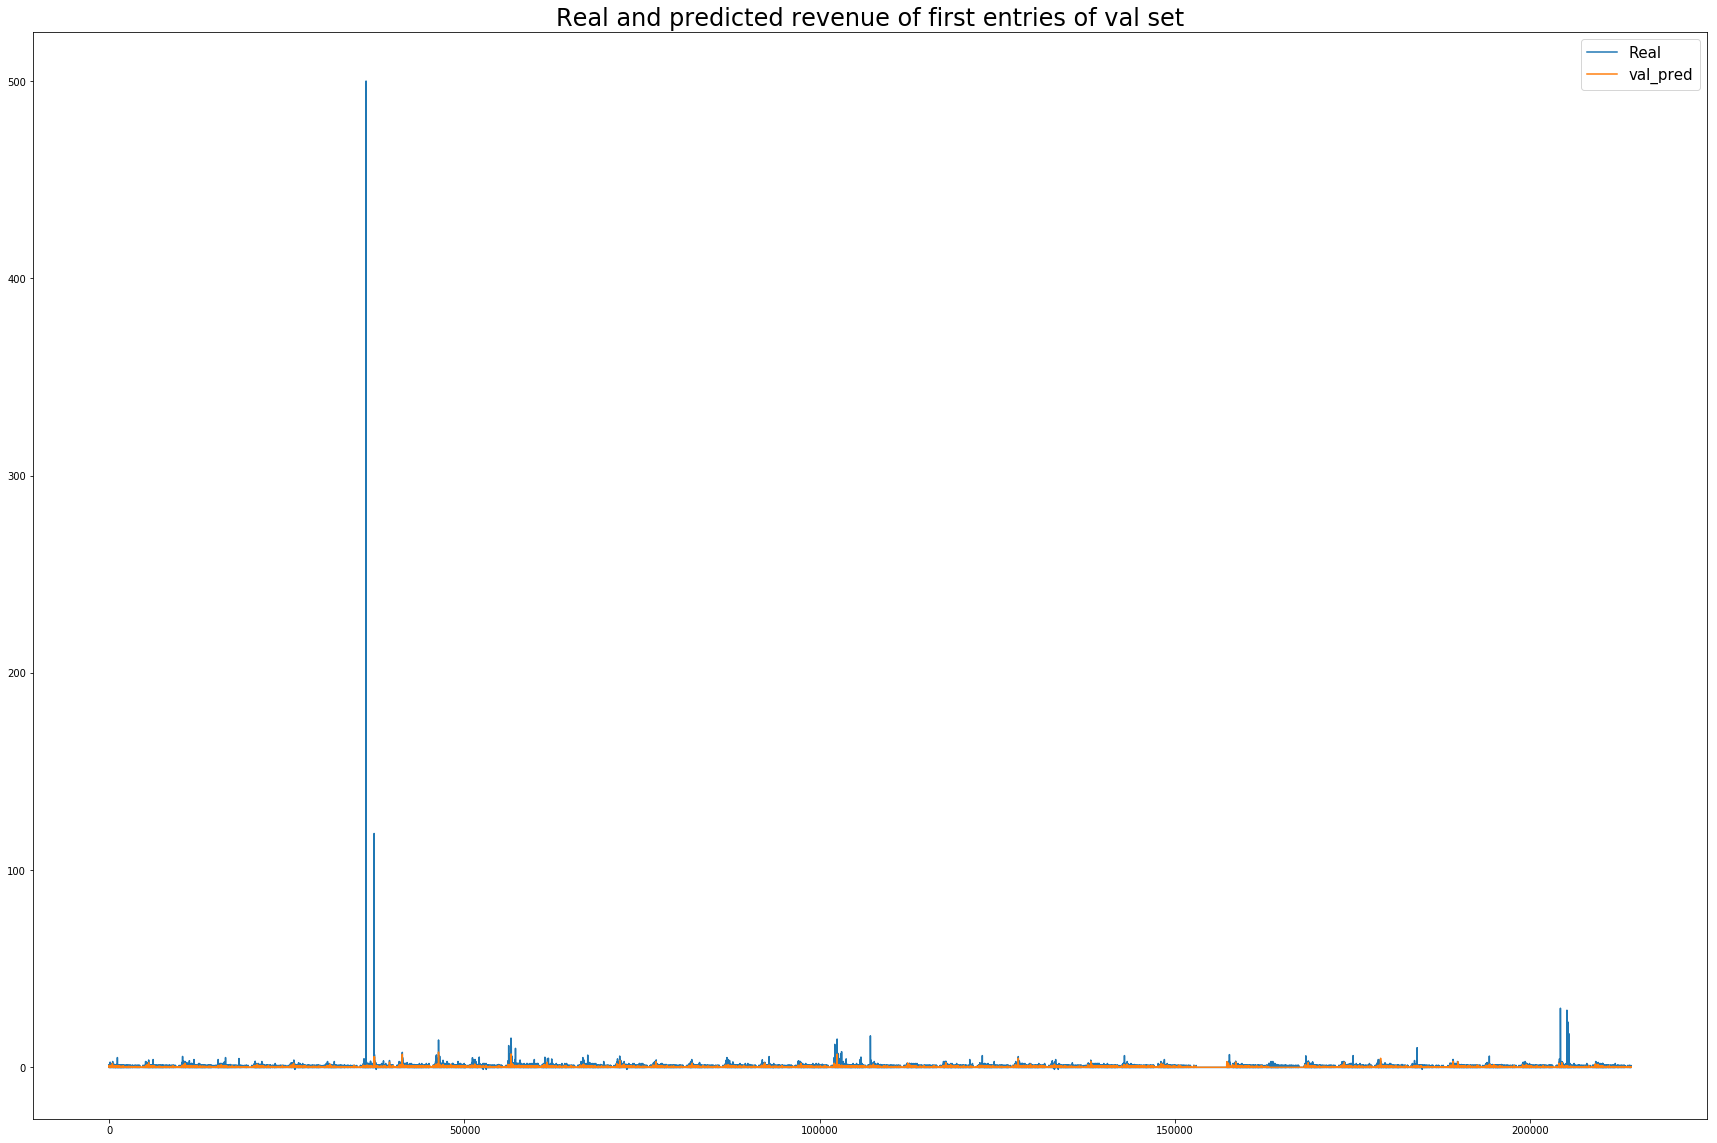

In [21]:
plt.figure(figsize=(30,20))
plt.plot(y_valid.reshape(X_test.shape[0]), label="Real")
plt.plot(y_val_pred, label="val_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first entries of val set",fontsize=24)
plt.show()

## Test

In [22]:
y_test = my_model.predict(X_test, verbose = 1).reshape(X_test.shape[0])
print(y_test.shape)

214200/214200 [==============================] - 124s 581us/step
(214200,)


In [26]:
#y_test = cnt_scaler.inverse_transform(y_test)
y_test= y_test.reshape(X_test.shape[0])
y_test = y_test.clip(0, 20)
sub = pd.DataFrame({'ID': test.ID, 'item_cnt_month': y_test})
sub.to_csv('submission2.csv', index = False)
print(sub.shape)
sub.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.403534
1,1,0.061175
2,2,0.495077
3,3,0.130894
4,4,0.061175


In [27]:
sub.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.134014
std,61834.358168,0.143085
min,0.000000,0.000799
25%,53549.750000,0.061175
50%,107099.500000,0.061409
75%,160649.250000,0.164919
max,214199.000000,7.734586
